# AI Challenge - Apply a supervised or semi-supervised ULMFiT model to Twitter US Airlines Sentiment 
## Prepared by - Bobby K Pappachan

**Objective :  Apply a supervised or semi-supervised ULMFiT model to Twitter US Airlines Sentiment**

Steps Used 
1. Import Packages and predefined fns #Step1
2. Data wrangling and cleaning #Step2
3. Language Model Training #Step3
4. Sentiment Model Classsification #Step4

In [1]:
#Step1 

from fastai import *
from fastai.text import *
import seaborn as sns

#function to replace twitter handle 
def replaceHandle(text):
    "Remove twitter handle"
    text = re.sub('@[^\s]+','',text)
    return text

#function to replace empty spaces 
def replace_useless_space(text):
    "Remove useless space"
    text = re.sub(' {2,}','',text)
    return text


**Data Wrangling**

In [2]:
#Step 2 Data wrangling
df_master = pd.read_csv('Tweets.csv')
df_airline = df_master[['airline_sentiment','text']].rename(columns={"airline_sentiment":'label'})

path=""

**Visualisation** :
Total sentiment tweet breakdown by airline

airline
American          2759
Delta             2222
Southwest         2420
US Airways        2913
United            3822
Virgin America     504
Name: tweet_id, dtype: int64

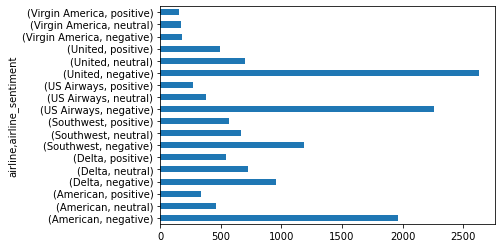

In [3]:
#Visualising sentiment count of each airline
total_tweets = df_master.groupby(['airline'])['tweet_id'].count()
ax = df_master.groupby(['airline','airline_sentiment'])['tweet_id'].count().plot.barh(rot=0)
total_tweets

**Data Cleaning** : Replacing redundancies

In [4]:
#Preparing Language Model and Classification Dataset  on Clean Data
df=df_airline

#Data cleaning
df_text = df.text.apply(replaceHandle)
df.text = df.text.apply(replace_useless_space)
valid_df = df.sample(frac=0.1) # validation set
train_df = df.drop(valid_df.index) # training set

#End of Step2

**Step 3 Model Training**

In [5]:
#Data Preparation 
data_lm = TextLMDataBunch.from_df(train_df=train_df, 
                                  valid_df=valid_df, path=path)

#Classifier model data 
data_clas = TextClasDataBunch.from_df(path=path, 
                                      train_df=train_df,
                                      valid_df=valid_df,
                                      vocab=data_lm.train_ds.vocab, bs=32)
data_lm.show_batch()

idx,text
0,"this playing . \n it 's really the only bad thing about flying xxup va xxbos @virginamerica yes , nearly every time i fly xxup vx this “ ear xxunk ” wo n’t go away :) xxbos @virginamerica xxmaj really missed a prime opportunity for xxmaj men xxmaj without xxmaj hats xxunk , there . https : / / t.co / xxunk xxbos @virginamerica xxmaj well , i didn't"
1,"thank you for the easy itinerary shift for impending weather . xxmaj quick , painless & & free . xxbos @virginamerica xxmaj thanks ! xxmaj good times there and back ! # xxmaj xxunk the entire flight xxunk # sfo xxbos @virginamerica beats expectations , shares take off - xxmaj santa xxmaj xxunk xxmaj sentinel http : / / t.co / xxunk g xxbos @virginamerica any plans to start flying"
2,- mco in a few weeks . xxmaj how long do we have to be at airport for before departure for both international and domestic ? xxmaj ta xxbos @united thanks xxbos @united xxmaj thanks . xxmaj it is on the same ticket . xxbos @united is the worst . xxmaj nonrefundable xxmaj first class tickets ? xxmaj oh because when you select xxmaj global / xxup fc their system
3,"seems strange to delay for xxmaj late xxmaj flight inbound xxunk hours from now , when the plane is already here . xxbos @united xxmaj thanks for the lack of help and the canned response from the 1 k desk ! xxbos xxunk 's too bad xxup ua has had another xxunk operational issue on my return flight . xxbos @united i would like to know what 's going on"
4,"currently on board so not now . xxmaj check in was terrible . xxmaj staff rude . xxmaj expensive luggage thrown around etc . xxbos @united fucked up , then voided my ticket , and xxup kept xxup my xxunk even an apology . i will never fly with your airline again . # unitedairlines xxbos @united has the xxup worst customer xxunk ! xxmaj this xxmaj kevin rep at"


In [6]:
data_clas.show_batch()

text,target
xxbos @united i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight 494 xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
"xxbos @usairways e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj problemss , reflight xxmaj booking xxmaj problemss , but y' all got me on the same flight out tonight ( not tomorrow ) & & the xxup fc upgrade . xxmaj thx !",positive
xxbos @virginamerica xxmaj many xxmaj thanks for the xxmaj follow . \n # ourprincess # freyasfund # xxup usa # xxmaj xxunk \n xxmaj looking for xxmaj any xxmaj help 😍 \n 💗 🇬 🇧 💗 🇺 🇸 💗 \n 🎀 🌏 🎀 http : / / t.co / xxunk,neutral
"xxbos @usairways 4 segments , 4 / 4 delayed . xxmaj gnv > xxup ctl . xxup ctl > xxup jan . xxup jan > xxup ctl . xxup ctl > xxup gnv . xxmaj my year off from flying with you guys was the way to go .",negative
xxbos @americanair xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup gma up here this xxup am .. so i understand .. xxmaj btw xxup a.a is my xxmaj airline when i m able to trv .. xxmaj love you guys . : ),positive


In [7]:
#Temporary Saving
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [8]:
#File Loading
#data_lm= TextLMDataBunch.load(path,'data_lm_export.pkl')
#data_clas= TextClasDataBunch.load(path,'data_clas_export.pkl', bs=16)

**Language Model Training**

In [9]:
#URLs.WT103 updated to AWD_LSTM
#language model training begin
lg_model = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5) #Regularisation hyperparameter -> drop_mult

In [10]:
#language model training one cycle 
lg_model.fit_one_cycle(1, 1e-2, moms=(0.8,0.7)) # Fine tuning last layers

epoch,train_loss,valid_loss,accuracy,time
0,4.706741,4.054991,0.250167,00:09


In [11]:
#Unfreezing the NN to train entire network
lg_model.unfreeze()
lg_model.fit_one_cycle(11, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.095016,3.934086,0.264286,00:09
1,3.971084,3.804402,0.280999,00:09
2,3.833684,3.713896,0.291099,00:09
3,3.678829,3.653635,0.297517,00:09
4,3.528828,3.623350,0.302846,00:09
5,3.384387,3.612814,0.303795,00:09
6,3.263780,3.619003,0.304381,00:09
7,3.139775,3.626359,0.303962,00:09
8,3.056382,3.636853,0.302902,00:09
9,2.995503,3.643367,0.303432,00:09


In [12]:
#Language Model Inference testing 
lg_model.predict("Todays flight was", n_words=20)

'Todays flight was worse when frequent travellers reported . Airlines avoid new airlines when boarding is Cancelled Flightled . xxbos'

**Saving Language Model for Teansfer Learning**

In [13]:
lg_model.save_encoder('lg_enc') #Saving encoder which deals with sentence understanding

#End of language moodel training 

**Sentiment Classifier Model Training using Transfer Learning(ULMFiT)**

In [14]:
sent_classfr = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5) 
sent_classfr.load_encoder('lg_enc') #Loading language model encoder to sentiment classifier
data_clas.show_batch()

text,target
xxbos @united i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight 494 xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
"xxbos @united xxmaj hi , i m flying xxup sfo - xxup lax - xxup xxunk - xxup xxunk . xxmaj my connecting time in xxup lax is xxunk m . xxmaj is it enough time ? xxmaj do i have to collect my bag and recheck on xxup xxunk ?",neutral
xxbos @americanair xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup gma up here this xxup am .. so i understand .. xxmaj btw xxup a.a is my xxmaj airline when i m able to trv .. xxmaj love you guys . : ),positive
xxbos @united xxup fail xxmaj you xxmaj cancelled xxmaj flightled our flight frm xxup xxunk and then used our reserv home to xxup iah ( from xxup sea ) for reflight xxmaj booking xxmaj problems w / out xxup our xxup permission ! ! # xxup ph6rps,negative
xxbos @americanair xxmaj took a flight yesterday fron xxup tpa - xxup dfw - xxup aus . xxmaj bag went to xxup iah . xxmaj today bag went to xxup iah - xxup dfw and then back to xxup iah . xxmaj still no bag !,negative


In [15]:
#model training one cycle on last layer
sent_classfr.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.620842,0.521677,0.796448,00:15


In [16]:
#model training one cycle on intermediate layer
sent_classfr.freeze_to(-4)
sent_classfr.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.546951,0.463544,0.814891,00:15


In [17]:
#Unfreezing the NN to train entire network
sent_classfr.unfreeze()
sent_classfr.fit_one_cycle(6, slice(2e-3/100, 2e-3))

#End of Model training

epoch,train_loss,valid_loss,accuracy,time
0,0.469518,0.428297,0.820355,00:16
1,0.459733,0.414422,0.835383,00:16
2,0.423219,0.415172,0.836749,00:17
3,0.371916,0.413158,0.833333,00:17
4,0.353818,0.431360,0.828552,00:16
5,0.326882,0.421573,0.836066,00:16


**Model Performance Results**

(Category positive, tensor(2), tensor([0.1920, 0.0296, 0.7784]))


Accuracy: 0.836


Text(0.5, 1.0, 'Classifation Confusion Matrix')

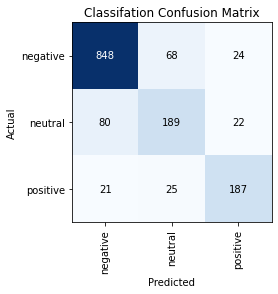

In [18]:
# Step 4 Results 
model = sent_classfr
print(model.predict("the flight was decent"))

interp = TextClassificationInterpretation.from_learner(model)
acc = accuracy(interp.preds, interp.y_true)
print('Accuracy: {0:.3f}'.format(acc))

interp.plot_confusion_matrix()
plt.title('Classifation Confusion Matrix')